# Predicting how long developers will stay in their current jobs

In this analysis, we will investigate what factors can "predict" how many years developers will stay in their current job.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from data_helpers import transform_coding_experience
from data_helpers import filter_employed_developers
from data_helpers import fillna_with_mean
from data_helpers import fillna_with_none
from data_helpers import encode_categorical_features
from data_helpers import transform_feature_on_popularity
from data_helpers import feature_popularity
from data_helpers import find_optimal_classifier
from data_helpers import set_dependent_variable
from data_helpers import add_number_of_different_roles

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True)

## Loading data

In [2]:
df = pd.read_csv('data/stackoverflow-2019/survey_results_public.csv')
df.shape

(88883, 85)

## Part III: What other factors lead developers stay longer in their jobs ?

To simplify the problem, we will reduce it to a binary classifier. Then, we have this binary dependent variable:

* 0 if developers are **Less than a year ago** in their current jobs
* 1, otherwise

This way, our model predict whether developers will stay more than **1 year** in the current job or not.

### Data preparation

In [3]:
df = filter_employed_developers(df)
df.shape

(68063, 85)

In [4]:
df = df[~df.LastHireDate.isna()]
df.loc[:,'MoreThanOneYear'] = df['LastHireDate'].apply(set_dependent_variable)
df['MoreThanOneYear'].value_counts()

1    43064
0    22378
Name: MoreThanOneYear, dtype: int64

### Feature Engineering

In [5]:
X = df.copy()

## Pre-selected features
X = X[['Hobbyist', 'OpenSourcer', 'Country', 'Student', 'EdLevel', 'EduOther', 'UndergradMajor', 'OrgSize', 'DevType',
        'YearsCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
        'MgrWant',  'JobSeek', 'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkRemote', 'WorkLoc', 'ImpSyn',
        'PurchaseWhat', 'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 
        'OpSys', 'DevEnviron', 'Gender', 'Age', 'Dependents'
       ]]

## What we want to predict
y = df[['MoreThanOneYear']]

X.shape

(65442, 34)

In [6]:
%%time

# Preparing years coding
for feature in ['YearsCode', 'YearsCodePro']:
    X[feature] = X[feature].fillna(value=-1)
    X.loc[:,feature] = X[feature].apply(transform_coding_experience)
    
# Filling numeric columns with the mean
num_features = X.select_dtypes(include=['float', 'int']).columns
X[num_features] = fillna_with_mean(X[num_features])

# Adding new features
X.loc[:,'differentRoles'] = X['DevType'].apply(add_number_of_different_roles)
        
# Encoding categorical variables
cat_features = X.select_dtypes(include=['object']).columns

# Categorical features transformed based on popularity
transformed_features = ['DevType', 'LanguageWorkedWith', 'DatabaseWorkedWith', 
                        'LanguageDesireNextYear', 'DatabaseDesireNextYear', 'DevEnviron']

for feature in transformed_features:
    X[feature] = fillna_with_none(X[[feature]])

    # Preparing dev type (Keep only the most popular one)
    f_popularity = feature_popularity(feature, X)
    X[feature] = X.apply(lambda r: transform_feature_on_popularity(r[feature], f_popularity), axis=1)
    
X = encode_categorical_features(X, cat_features)
X.shape

CPU times: user 9.09 s, sys: 1.62 s, total: 10.7 s
Wall time: 10.8 s


(65442, 861)

In [7]:
y.shape

(65442, 1)

### Finding the optimal model

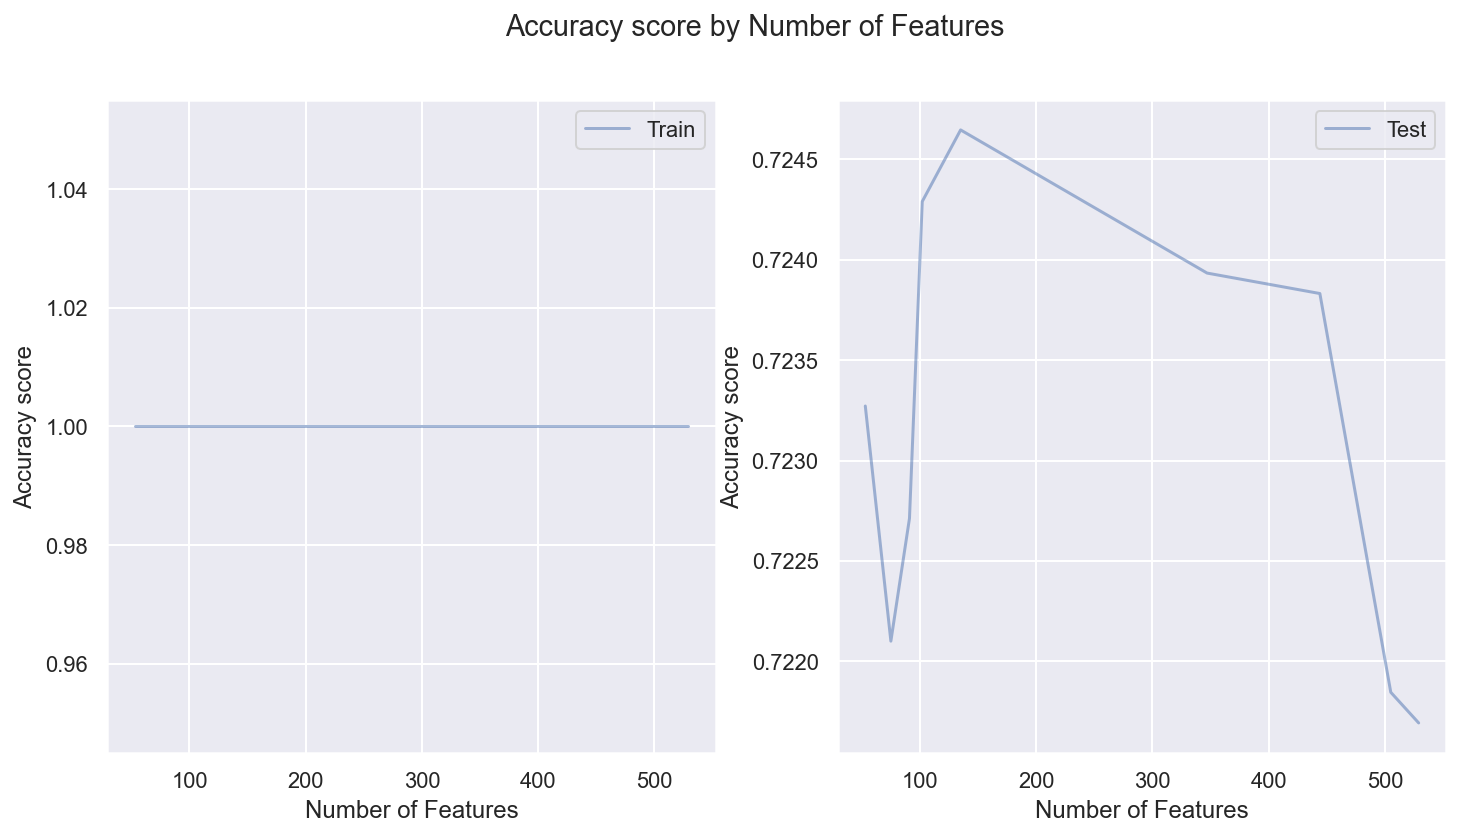

CPU times: user 12min 31s, sys: 6.04 s, total: 12min 37s
Wall time: 12min 42s


In [8]:
%%time 

# Defining threshold to cut features off
cutoffs = [10000, 5000, 3500, 2500, 1000, 100, 50, 30, 25]

# This function will run many experiments to find optmial model and plot the results
accuracy_train_scores, accuracy_test_scores, classifier, X_test, y_test = find_optimal_classifier(X, y, cutoffs, 
                                                                    n_estimators = 500, test_size = .30, 
                                                                    random_state = 42, plot = True)

In [9]:
## Number of features for the optimal model
classifier.n_features_

135

As we can observe in the plot above, the optimal number of features is **135** and the model accuracy in the test set is **~73%**.

### Analyzing feature importance

In this analysis, more important than accuracy is to understand the importance of each feature to predict whether developers will stay more than 1 year in their jobs.

In [10]:
Xf = X_test.copy()

In [11]:
Xf['pred'] = classifier.predict(X_test)
Xf.head()

,YearsCode,YearsCodePro,CompTotal,ConvertedComp,WorkWeekHrs,Age,differentRoles,Hobbyist_Yes,OpenSourcer_Less than once per year,OpenSourcer_Never,...,DevEnviron_Atom,DevEnviron_IntelliJ,DevEnviron_Notepad++,DevEnviron_Sublime Text,DevEnviron_Vim,DevEnviron_Visual Studio,DevEnviron_Visual Studio Code,Gender_Woman,Dependents_Yes,pred
25100,1.0,0.5,22000.0,25206.0,40.0,27.0,6,1,0,1,...,0,0,0,0,0,0,1,0,0,0
67254,6.0,4.0,75000.0,75000.0,40.0,23.0,3,1,0,0,...,0,1,0,0,0,0,0,0,0,1
69193,12.0,8.0,70000.0,70000.0,56.0,37.0,4,1,0,1,...,0,0,0,0,0,1,0,0,0,1
59573,3.0,2.0,6000.0,17352.0,30.0,30.0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1
29780,36.0,30.0,57000.0,65308.0,40.0,49.0,2,1,1,0,...,0,0,0,0,0,0,1,0,1,1


In [12]:
shap.initjs() 
explainer = shap.TreeExplainer(classifier)

Picking randomly a sample instance classified as **1** which means the developer is more than 1 year in the current job:

In [13]:
shap.initjs() 
choosen_instance = Xf[Xf.pred == 1].sample(1, random_state=42).drop('pred', axis=1)
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

We have hapley values for the features. Feature values in pink increases the prediction. Size of the bar is the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. In this sample, we can observe the following features contributed more to have a positive classification (class = 1):

* `JobSeek: I am not interested in new job opportunities = 0`
* `YearsCode = 14`
* `YearsCodePro = 5`
* `differentRoles = 7`

In this case, the candidate is more than 1 year in the current job when these conditions happen:
* Not looking for a new job
* Have good experience (at least 5 coding as a professional)
* Assume different job roles 

Similarly, we pick randomly a sample instance classified as **0** which means the developer is less than 1 year in the current job:

In [14]:
shap.initjs() 
choosen_instance = Xf[Xf.pred == 0].sample(1, random_state=42).drop('pred', axis=1)
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In this case, these features contributed more to have a negative classification (class = 0):

* `YearsCodePro = -1`
* `YearsCode = 6`
* `Student_Yes, full-time = 1`
* `Age = 25`

In this case, the candidate is less than 1 year in the current job when these conditions happen:
* Low professional experience
* It is a full time student
* Young age

#### Analyzing features impact on a higher scale

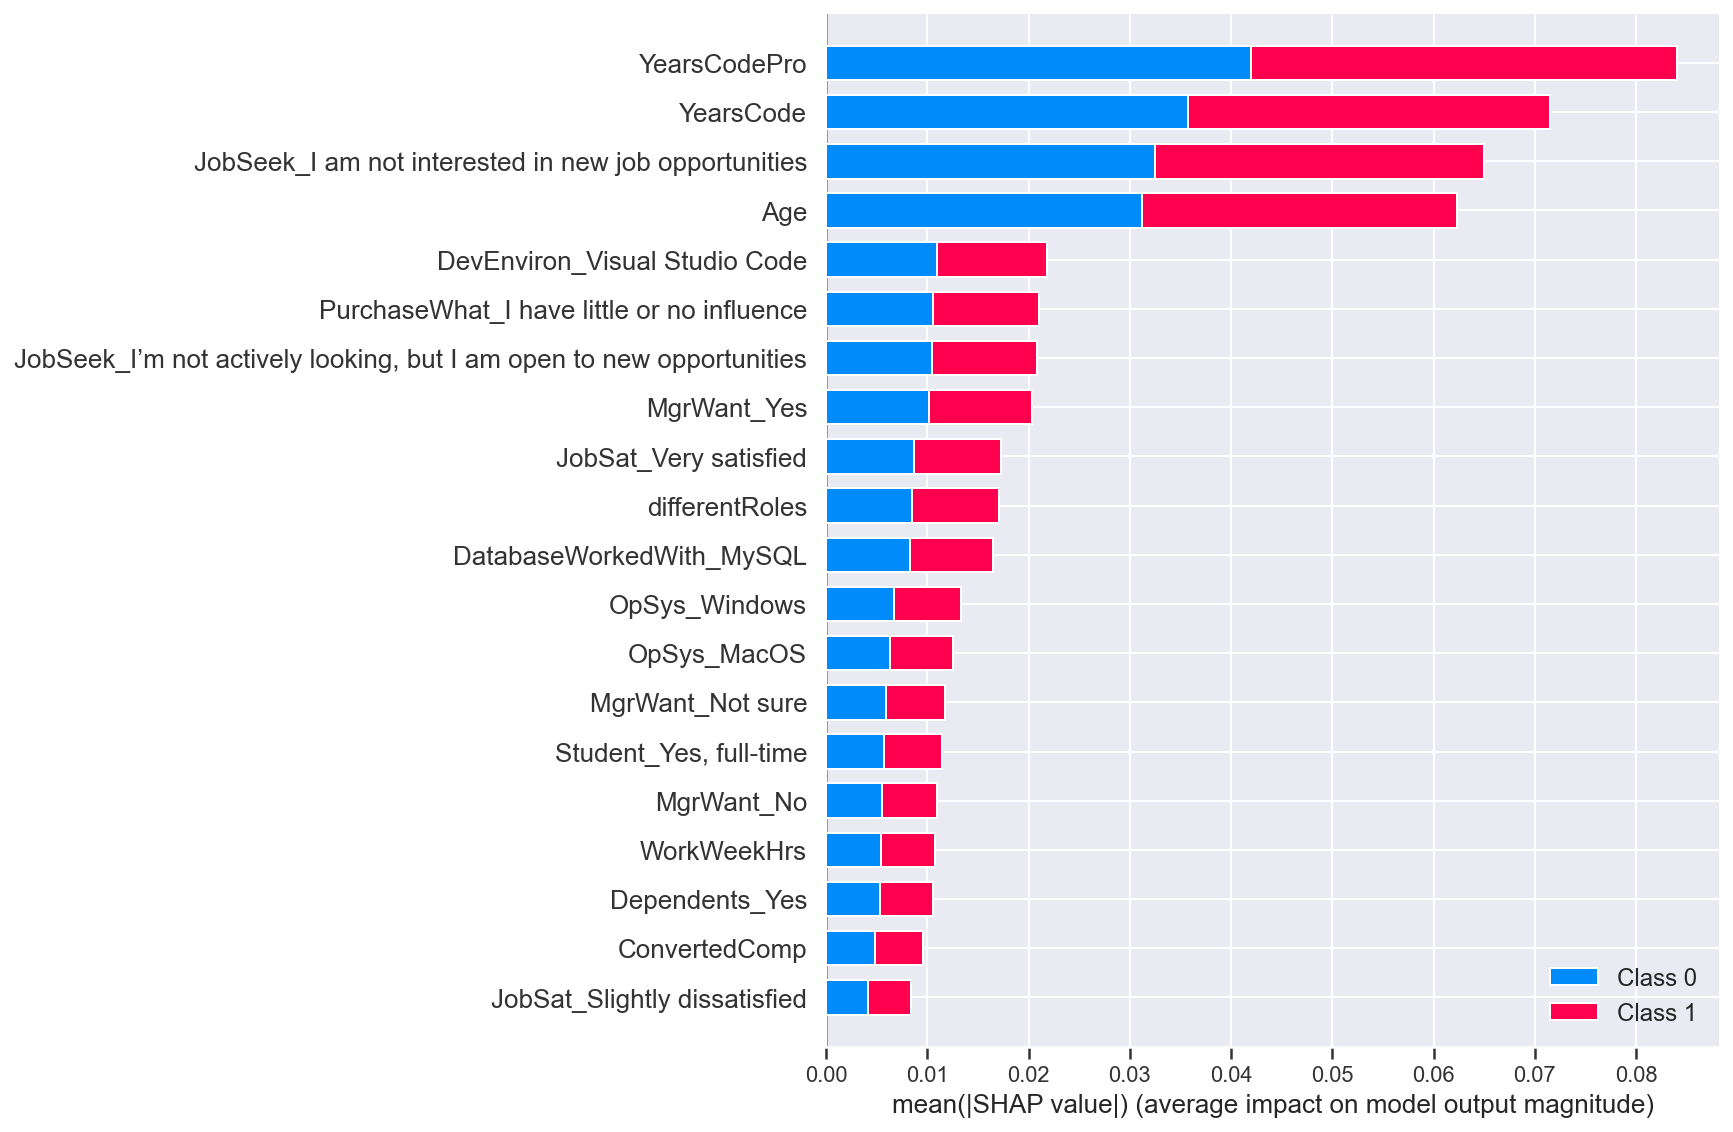

CPU times: user 17min 18s, sys: 5.81 s, total: 17min 24s
Wall time: 17min 25s


In [15]:
%%time
sample = X_test.sample(100, random_state=42)

shap_values = explainer.shap_values(sample) 
shap.summary_plot(shap_values, sample)

By analyzing a sample of 100 randomly picked instances, we can confirm what we had already observed. The current developer coding experience, the fact the developer is not looking for a new job and the person's age are the major factors to determine whether developer will stay longer than 1 year in the current job or not.